
# UTKFace — Edad (Regresión) con Enfoque en Menores (0–18)

Este notebook entrena un **modelo multitarea** (regresión de edad + clasificación por rangos)
enfocado en **minimizar errores en menores** (0–18), especialmente en adolescentes (13–18).
Incluye:
- Pipeline `tf.data` desde carpeta local del dataset UTKFace (formato de archivo: `edad_genero_raza_*.jpg`).
- **Pérdida ponderada** para dar más peso a errores en menores: `weighted_MAE`.
- **Cabezal auxiliar** de clasificación en 4 buckets: Niño (0–12), Adolescente (13–18), Adulto Joven (19–30), Adulto (31+).
- Métricas por subgrupos, **MAE en menores**, y umbral conservador para filtrar acceso.
- Callbacks para early stopping y mejor modelo.

> **Requisitos:** TensorFlow 2.10+ (o compatible con tu GPU), Pillow, scikit-learn.


In [1]:

# === Configuración ===
DATA_DIR = '/kaggle/input/utkface-new/UTKFace/'
IMG_SIZE = (224, 224)
BATCH_SIZE = 64
SEED = 42

# Ponderaciones de pérdidas
LOSS_W_AGE = 0.7
LOSS_W_BUCKET = 0.3

# Peso extra a errores en menores (<19)
MINOR_AGE_CUTOFF = 19
WEIGHT_FOR_MINOR = 3.0
WEIGHT_FOR_ADULT = 1.0

# Entrenamiento
EPOCHS = 60
LEARNING_RATE = 1e-4


In [2]:

import os, re, math, random, glob, json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import EfficientNetB0
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, classification_report
from PIL import Image

print("TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))


2025-08-18 03:46:39.055261: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755488799.428050      71 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755488799.531319      71 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow: 2.18.0
GPU disponible: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]


In [3]:

# === Cargar rutas y extraer edades del nombre de archivo ===
# Formato UTKFace: [age]_[gender]_[race]_[date&time].jpg
pat = re.compile(r"^(\d+)_([01])_([0-4])_.*\.jpg$", re.I)

paths = sorted(glob.glob(os.path.join(DATA_DIR, "*.jpg")))
ages = []
file_paths = []

for p in paths:
    fname = os.path.basename(p)
    m = pat.match(fname)
    if not m:
        continue
    age = int(m.group(1))
    # Filtramos edades imposibles si existieran (por seguridad)
    if age < 0 or age > 116:
        continue
    ages.append(age)
    file_paths.append(p)

ages = np.array(ages, dtype=np.float32)
file_paths = np.array(file_paths)
print("Total imágenes válidas:", len(file_paths))
print("Rango de edades:", ages.min(), "->", ages.max())


Total imágenes válidas: 23705
Rango de edades: 1.0 -> 116.0


In [4]:

# === Buckets de edad ===
# 0: Niño (0–12), 1: Adolescente (13–18), 2: Adulto Joven (19–30), 3: Adulto (31+)
def age_to_bucket(age):
    a = int(age)
    if a <= 12: return 0
    if a <= 18: return 1
    if a <= 30: return 2
    return 3

buckets = np.array([age_to_bucket(a) for a in ages], dtype=np.int32)
class_names = ["child(0-12)", "teen(13-18)", "young(19-30)", "adult(31+)"]
unique, counts = np.unique(buckets, return_counts=True)
print("Distribución buckets:", dict(zip([class_names[u] for u in unique], counts)))


Distribución buckets: {'child(0-12)': 3413, 'teen(13-18)': 1082, 'young(19-30)': 8166, 'adult(31+)': 11044}


In [5]:

# === Split estratificado por buckets ===
train_idx, test_idx = train_test_split(
    np.arange(len(file_paths)), test_size=0.15, random_state=SEED, stratify=buckets
)
train_idx, val_idx = train_test_split(
    train_idx, test_size=0.1765, random_state=SEED, stratify=buckets[train_idx]
)  # ~15% val, 70% train, 15% test

def take(idx):
    return file_paths[idx], ages[idx], buckets[idx]

train_paths, train_ages, train_buckets = take(train_idx)
val_paths, val_ages, val_buckets = take(val_idx)
test_paths, test_ages, test_buckets = take(test_idx)

print("Train:", len(train_paths), " Val:", len(val_paths), " Test:", len(test_paths))

# Chequear representación de adolescentes en splits
def bucket_stats(name, b):
    u,c = np.unique(b, return_counts=True)
    print(name, dict(zip(u, c)))

bucket_stats("Train buckets", train_buckets)
bucket_stats("Val buckets", val_buckets)
bucket_stats("Test buckets", test_buckets)


Train: 16592  Val: 3557  Test: 3556
Train buckets {0: 2389, 1: 757, 2: 5716, 3: 7730}
Val buckets {0: 512, 1: 163, 2: 1225, 3: 1657}
Test buckets {0: 512, 1: 162, 2: 1225, 3: 1657}


In [6]:

# === tf.data pipeline ===
AUTOTUNE = tf.data.AUTOTUNE

def preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img

def augment(img):
    # Aumentos suaves que no distorsionan facciones
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_contrast(img, 0.9, 1.1)
    img = tf.image.random_brightness(img, 0.05)
    # recorte aleatorio leve
    crop_frac = tf.random.uniform([], 0.9, 1.0)
    new_size = tf.cast(tf.multiply(tf.constant(IMG_SIZE, tf.float32), crop_frac), tf.int32)
    img = tf.image.resize_with_crop_or_pad(img, IMG_SIZE[0], IMG_SIZE[1])
    img = tf.image.resize(img, IMG_SIZE)
    return img

def make_ds(paths, ages, buckets, train=False):
    ds_paths = tf.data.Dataset.from_tensor_slices(paths)
    ds_ages = tf.data.Dataset.from_tensor_slices(ages)
    ds_buckets = tf.data.Dataset.from_tensor_slices(buckets)
    ds = tf.data.Dataset.zip((ds_paths, ds_ages, ds_buckets))

    def _map(path, age, bucket):
        img = preprocess_image(path)
        if train:
            img = augment(img)
        # targets: age (float), buckets one-hot
        bucket_oh = tf.one_hot(bucket, 4, dtype=tf.float32)
        return img, {"age": tf.expand_dims(age, -1), "bucket": bucket_oh}

    if train:
        ds = ds.shuffle(8192, seed=SEED, reshuffle_each_iteration=True)
    ds = ds.map(_map, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(AUTOTUNE)
    return ds

train_ds = make_ds(train_paths, train_ages, train_buckets, train=True)
val_ds   = make_ds(val_paths,   val_ages,   val_buckets,   train=False)
test_ds  = make_ds(test_paths,  test_ages,  test_buckets,  train=False)


I0000 00:00:1755488818.955250      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1755488818.955918      71 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [7]:

# === Pérdida ponderada para priorizar menores ===
@tf.function
def weighted_mae(y_true, y_pred):
    # y_true shape: (batch, 1)
    age_true = y_true[:, 0]
    weights = tf.where(age_true < MINOR_AGE_CUTOFF, WEIGHT_FOR_MINOR, WEIGHT_FOR_ADULT)
    mae = tf.abs(y_true - y_pred)[:, 0]
    return tf.reduce_mean(weights * mae)


In [8]:

# === Modelo multitarea ===
base = EfficientNetB0(include_top=False, input_shape=IMG_SIZE+(3,), weights='imagenet', pooling='avg')
x = layers.Dropout(0.3)(base.output)

age_output = layers.Dense(1, activation='linear', name='age')(x)
bucket_output = layers.Dense(4, activation='softmax', name='bucket')(x)

model = models.Model(inputs=base.input, outputs=[age_output, bucket_output])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss={'age': weighted_mae, 'bucket': 'categorical_crossentropy'},
    loss_weights={'age': LOSS_W_AGE, 'bucket': LOSS_W_BUCKET},
    metrics={
        'age': ['mae'],
        'bucket': ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]
    }
)
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 4,013,953 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [9]:

# === Callbacks ===
ckpt_path = "best_utkface_minor_focus.keras"
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(ckpt_path, monitor='val_bucket_recall', mode='max', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_bucket_recall', mode='max', patience=8, restore_best_weights=True, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]


In [10]:

# === Entrenamiento ===
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/60


I0000 00:00:1755488877.476946     103 service.cc:148] XLA service 0x7867f80149e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755488877.478506     103 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1755488877.478528     103 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1755488882.914292     103 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1755488898.000056     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755488898.155633     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755488898.731413     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

259/260 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - age_loss: 28.5559 - age_mae: 26.8857 - bucket_accuracy: 0.5194 - bucket_loss: 1.0901 - bucket_precision: 0.6643 - bucket_recall: 0.2465 - loss: 20.3162

E0000 00:00:1755488994.234823     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755488994.373851     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755488994.711030     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1755488994.851457     103 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - age_loss: 28.5308 - age_mae: 26.8621 - bucket_accuracy: 0.5197 - bucket_loss: 1.0895 - bucket_precision: 0.6645 - bucket_recall: 0.2472 - loss: 20.2985
Epoch 1: val_bucket_recall improved from -inf to 0.13410, saving model to best_utkface_minor_focus.keras
260/260 ━━━━━━━━━━━━━━━━━━━━ 213s 444ms/step - age_loss: 28.5059 - age_mae: 26.8387 - bucket_accuracy: 0.5201 - bucket_loss: 1.0888 - bucket_precision: 0.6647 - bucket_recall: 0.2478 - loss: 20.2809 - val_age_loss: 32.3972 - val_age_mae: 30.3230 - val_bucket_accuracy: 0.1513 - val_bucket_loss: 2.1509 - val_bucket_precision: 0.1412 - val_bucket_recall: 0.1341 - val_loss: 23.3044 - learning_rate: 1.0000e-04
Epoch 2/60
260/260 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - age_loss: 10.8880 - age_mae: 9.7130 - bucket_accuracy: 0.7203 - bucket_loss: 0.6631 - bucket_precision: 0.7630 - bucket_recall: 0.6627 - loss: 7.8205
Epoch 2: val_bucket_recall improved from 0.13410 to 0.14394, saving model to best_u

In [11]:

# === Evaluación detallada ===
pred_age, pred_bucket_prob = model.predict(test_ds, verbose=1)
y_true_age = []
y_true_bucket = []

for _, y in test_ds:
    y_true_age.append(y['age'].numpy())
    y_true_bucket.append(y['bucket'].numpy())
y_true_age = np.concatenate(y_true_age, axis=0)[:,0]
y_true_bucket = np.argmax(np.concatenate(y_true_bucket, axis=0), axis=1)

pred_age = pred_age[:,0]
pred_bucket = np.argmax(pred_bucket_prob, axis=1)

mae_global = mean_absolute_error(y_true_age, pred_age)
print("MAE global:", round(mae_global, 3))

def subgroup_mae(mask, name):
    if mask.sum() == 0:
        print(f"{name}: sin datos")
        return
    print(f"{name} MAE:", round(mean_absolute_error(y_true_age[mask], pred_age[mask]), 3))

mask_child = (y_true_age <= 12)
mask_teen  = (y_true_age >= 13) & (y_true_age <= 18)
mask_young = (y_true_age >= 19) & (y_true_age <= 30)
mask_adult = (y_true_age >= 31)

subgroup_mae(mask_child, "Niños (0–12)")
subgroup_mae(mask_teen,  "Adolescentes (13–18)")
subgroup_mae(mask_young, "Adultos jóvenes (19–30)")
subgroup_mae(mask_adult, "Adultos (31+)")

print("\nReporte de clasificación por buckets (pred vs real):")
print(classification_report(y_true_bucket, pred_bucket, target_names=class_names, digits=3))


56/56 ━━━━━━━━━━━━━━━━━━━━ 23s 294ms/step
MAE global: 5.124
Niños (0–12) MAE: 1.795
Adolescentes (13–18) MAE: 4.509
Adultos jóvenes (19–30) MAE: 4.14
Adultos (31+) MAE: 6.941

Reporte de clasificación por buckets (pred vs real):
              precision    recall  f1-score   support

 child(0-12)      0.933     0.926     0.929       512
 teen(13-18)      0.590     0.383     0.464       162
young(19-30)      0.719     0.820     0.766      1225
  adult(31+)      0.872     0.813     0.841      1657

    accuracy                          0.812      3556
   macro avg      0.779     0.735     0.750      3556
weighted avg      0.815     0.812     0.811      3556



In [12]:

# === Política conservadora para acceso ===
# Regla: si el modelo predice "adolescente" con prob >= teen_threshold y edad_pred < 21,
# forzar edad final = min(edad_pred, 18). Esto reduce falsos negativos (menores que pasan).
teen_threshold = 0.35  # puedes ajustar entre 0.3 y 0.6 según recall
teen_index = 1

def final_age_and_access(age_pred, bucket_prob, teen_threshold=teen_threshold):
    teen_prob = float(bucket_prob[teen_index])
    final_age = float(age_pred)
    if teen_prob >= teen_threshold and final_age < 21:
        final_age = min(final_age, 18.0)
    # Política de acceso: permitir solo si final_age >= 18.5 (margen de seguridad)
    can_access = final_age >= 18.5
    return final_age, can_access

# Ejemplo usando el primer batch del test
for imgs, y in test_ds.take(1):
    pa, pb = model.predict(imgs, verbose=0)
    for i in range(min(5, len(pa))):
        fa, ok = final_age_and_access(pa[i][0], pb[i])
        print(f"Edad_pred={pa[i][0]:.2f} -> Edad_final={fa:.2f} | Acceso={'PERMITIDO' if ok else 'DENEGADO'}")


Edad_pred=29.09 -> Edad_final=29.09 | Acceso=PERMITIDO
Edad_pred=55.97 -> Edad_final=55.97 | Acceso=PERMITIDO
Edad_pred=2.38 -> Edad_final=2.38 | Acceso=DENEGADO
Edad_pred=34.09 -> Edad_final=34.09 | Acceso=PERMITIDO
Edad_pred=32.95 -> Edad_final=32.95 | Acceso=PERMITIDO


In [13]:

# === Guardar historia y notas ===
with open("training_history_minor_focus.json", "w", encoding="utf-8") as f:
    json.dump({k: [float(x) for x in v] for k,v in history.history.items()}, f, ensure_ascii=False, indent=2)

print("Guardado: best model ->", "best_utkface_minor_focus.keras")
print("Guardado: history -> training_history_minor_focus.json")


Guardado: best model -> best_utkface_minor_focus.keras
Guardado: history -> training_history_minor_focus.json



## Consejos y Ajustes
- **Si el modelo deja pasar menores** (falsos negativos):
  - Aumenta `WEIGHT_FOR_MINOR` a 4.0 o 5.0.
  - Baja `teen_threshold` a 0.3 y/o sube el umbral de acceso a `>= 19.0`.
  - Aumenta `LOSS_W_BUCKET` a 0.4 para reforzar la cabeza de clasificación.
- **Si el MAE en adultos sube mucho** pero menores están bien, está bien para tu caso de uso (seguridad).
- **Batch size**: si te quedas sin VRAM, baja a 32.
- **Backbone**: puedes cambiar a `ResNet50` si EfficientNet no te rinde igual en tu GPU.
- **Data leakage**: asegúrate de que los splits no se mezclen si usas subsets externos.
- **Evaluación realista**: prueba con imágenes propias (sin barba/afeitado/maquillaje y con), para ver comportamiento conservador.


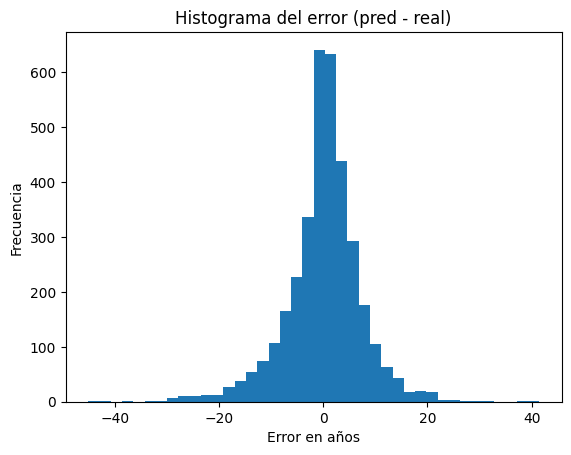

In [14]:
import numpy as np
import matplotlib.pyplot as plt

errors = pred_age - y_true_age  # >0 = sobreestima, <0 = subestima

plt.figure()
plt.hist(errors, bins=40)
plt.title("Histograma del error (pred - real)")
plt.xlabel("Error en años")
plt.ylabel("Frecuencia")
plt.show()

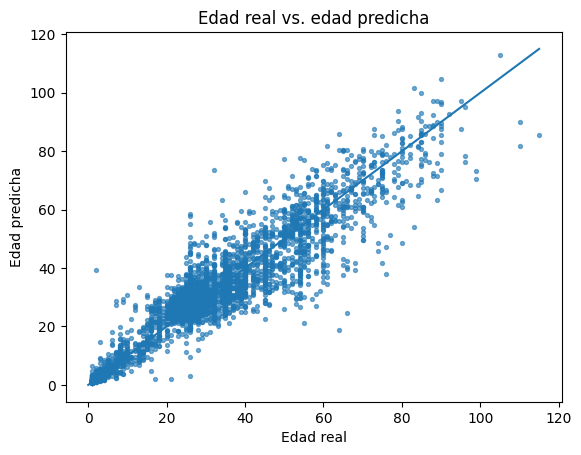

In [15]:
plt.figure()
plt.scatter(y_true_age, pred_age, s=8, alpha=0.6)
min_age = max(0, int(min(y_true_age.min(), pred_age.min())))
max_age = int(max(y_true_age.max(), pred_age.max()))
plt.plot([min_age, max_age], [min_age, max_age])
plt.title("Edad real vs. edad predicha")
plt.xlabel("Edad real")
plt.ylabel("Edad predicha")
plt.show()

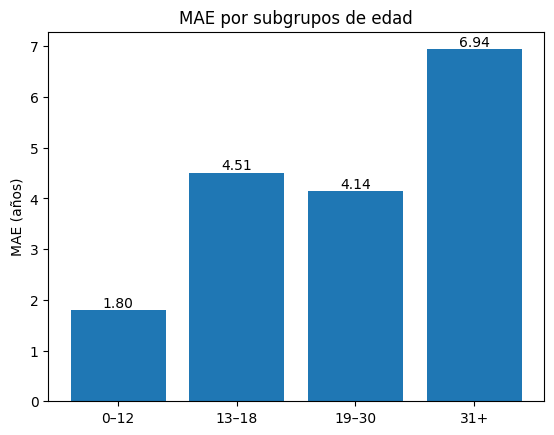

In [16]:
from sklearn.metrics import mean_absolute_error

mask_child = (y_true_age <= 12)
mask_teen  = (y_true_age >= 13) & (y_true_age <= 18)
mask_young = (y_true_age >= 19) & (y_true_age <= 30)
mask_adult = (y_true_age >= 31)

labels = ["0–12", "13–18", "19–30", "31+"]
maes = [
    mean_absolute_error(y_true_age[mask_child], pred_age[mask_child]) if mask_child.any() else np.nan,
    mean_absolute_error(y_true_age[mask_teen],  pred_age[mask_teen])  if mask_teen.any()  else np.nan,
    mean_absolute_error(y_true_age[mask_young], pred_age[mask_young]) if mask_young.any() else np.nan,
    mean_absolute_error(y_true_age[mask_adult], pred_age[mask_adult]) if mask_adult.any() else np.nan,
]

plt.figure()
plt.bar(labels, maes)
plt.title("MAE por subgrupos de edad")
plt.ylabel("MAE (años)")
for i, v in enumerate(maes):
    if not np.isnan(v):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")
plt.show()

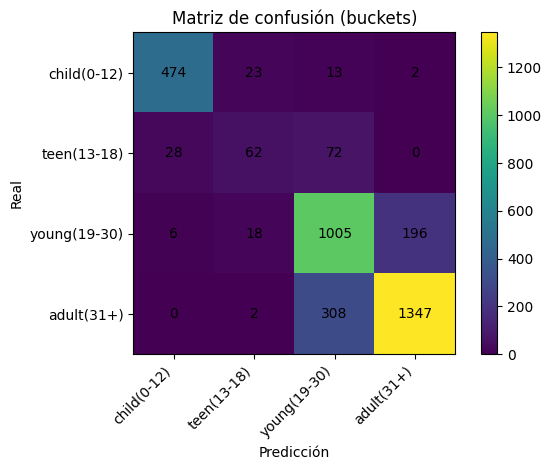

In [17]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true_bucket, pred_bucket, labels=[0,1,2,3])
plt.figure()
plt.imshow(cm, interpolation='nearest')
plt.title("Matriz de confusión (buckets)")
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45, ha='right')
plt.yticks(tick_marks, class_names)
plt.xlabel("Predicción")
plt.ylabel("Real")

# Anotar valores
th = cm.max() / 2.0 if cm.size > 0 else 0
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")

plt.tight_layout()
plt.show()

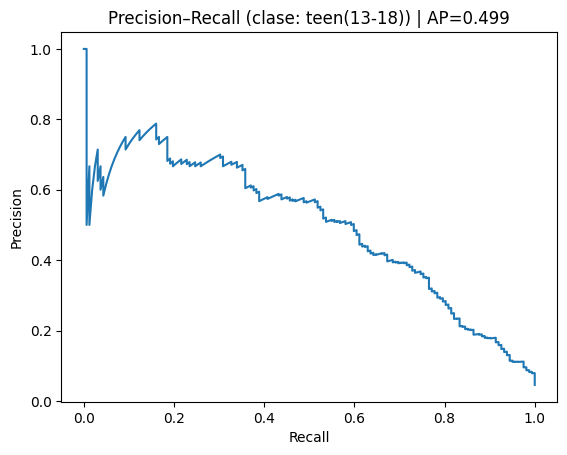

In [18]:
from sklearn.metrics import precision_recall_curve, average_precision_score

teen_index = 1
y_true_teen = (y_true_bucket == teen_index).astype(int)
y_score_teen = pred_bucket_prob[:, teen_index]

precision, recall, thresholds = precision_recall_curve(y_true_teen, y_score_teen)
ap = average_precision_score(y_true_teen, y_score_teen)

plt.figure()
plt.plot(recall, precision)
plt.title(f"Precision–Recall (clase: {class_names[teen_index]}) | AP={ap:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()

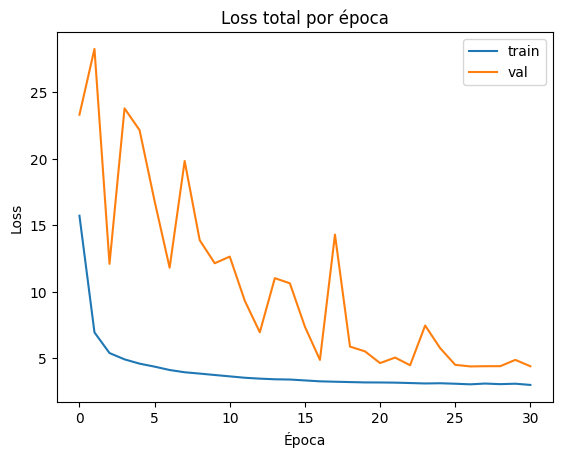

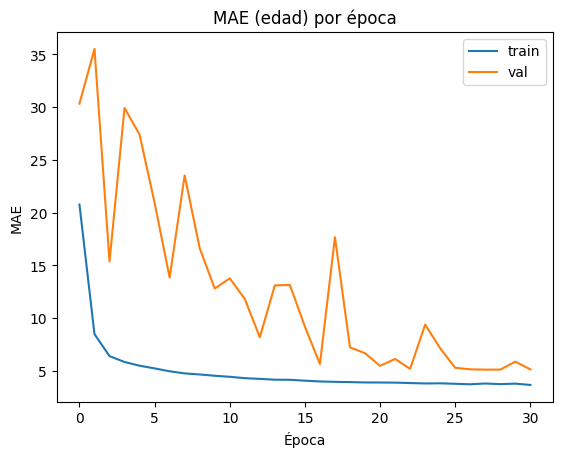

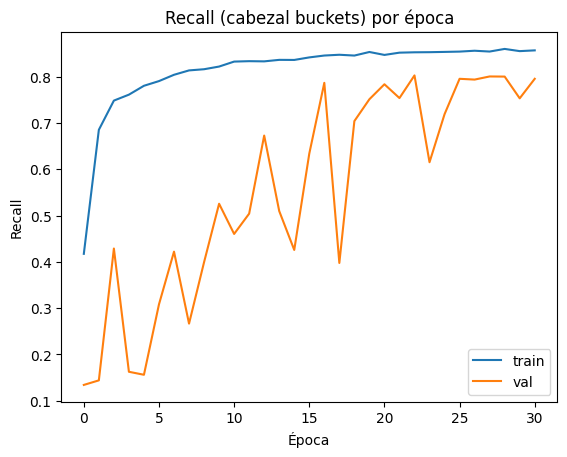

In [19]:
H = history.history  # dict

# Loss total
if "loss" in H and "val_loss" in H:
    plt.figure()
    plt.plot(H["loss"], label="train")
    plt.plot(H["val_loss"], label="val")
    plt.title("Loss total por época")
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

# MAE de edad (cabezal de regresión)
if "age_mae" in H and "val_age_mae" in H:
    plt.figure()
    plt.plot(H["age_mae"], label="train")
    plt.plot(H["val_age_mae"], label="val")
    plt.title("MAE (edad) por época")
    plt.xlabel("Época")
    plt.ylabel("MAE")
    plt.legend()
    plt.show()

# Recall de buckets (en especial adolescentes en validación)
# Nota: Keras registra 'bucket_recall' y 'val_bucket_recall' para la cabeza de clasificación
if "bucket_recall" in H and "val_bucket_recall" in H:
    plt.figure()
    plt.plot(H["bucket_recall"], label="train")
    plt.plot(H["val_bucket_recall"], label="val")
    plt.title("Recall (cabezal buckets) por época")
    plt.xlabel("Época")
    plt.ylabel("Recall")
    plt.legend()
    plt.show()

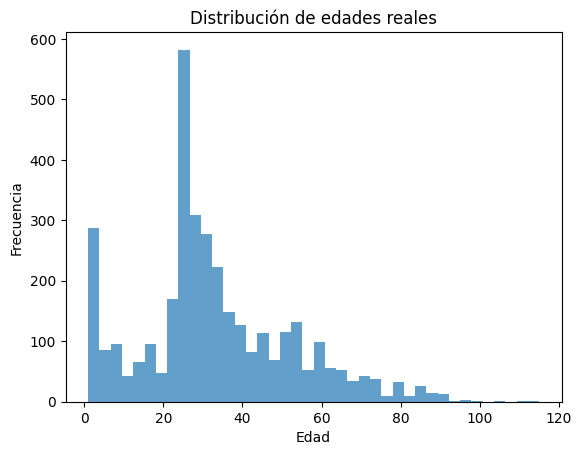

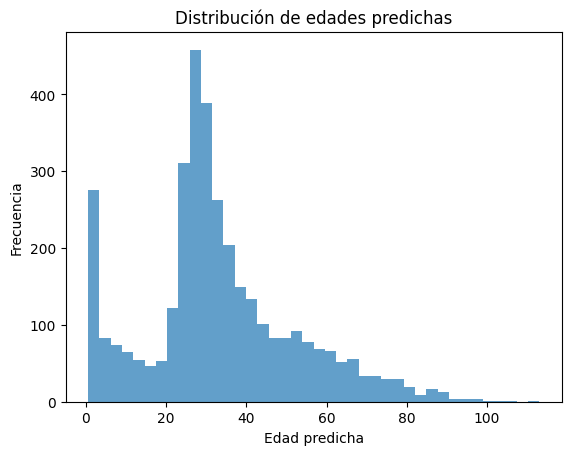

In [20]:
plt.figure()
plt.hist(y_true_age, bins=40, alpha=0.7)
plt.title("Distribución de edades reales")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()

plt.figure()
plt.hist(pred_age, bins=40, alpha=0.7)
plt.title("Distribución de edades predichas")
plt.xlabel("Edad predicha")
plt.ylabel("Frecuencia")
plt.show()